# AnoGAN
- GAN을 활용한 Anomaly Detection 방법

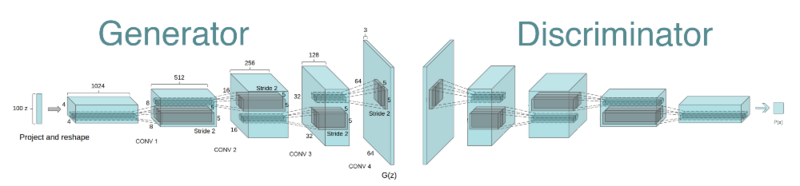

- Normal Data만을 가지고 DCGAN 학습

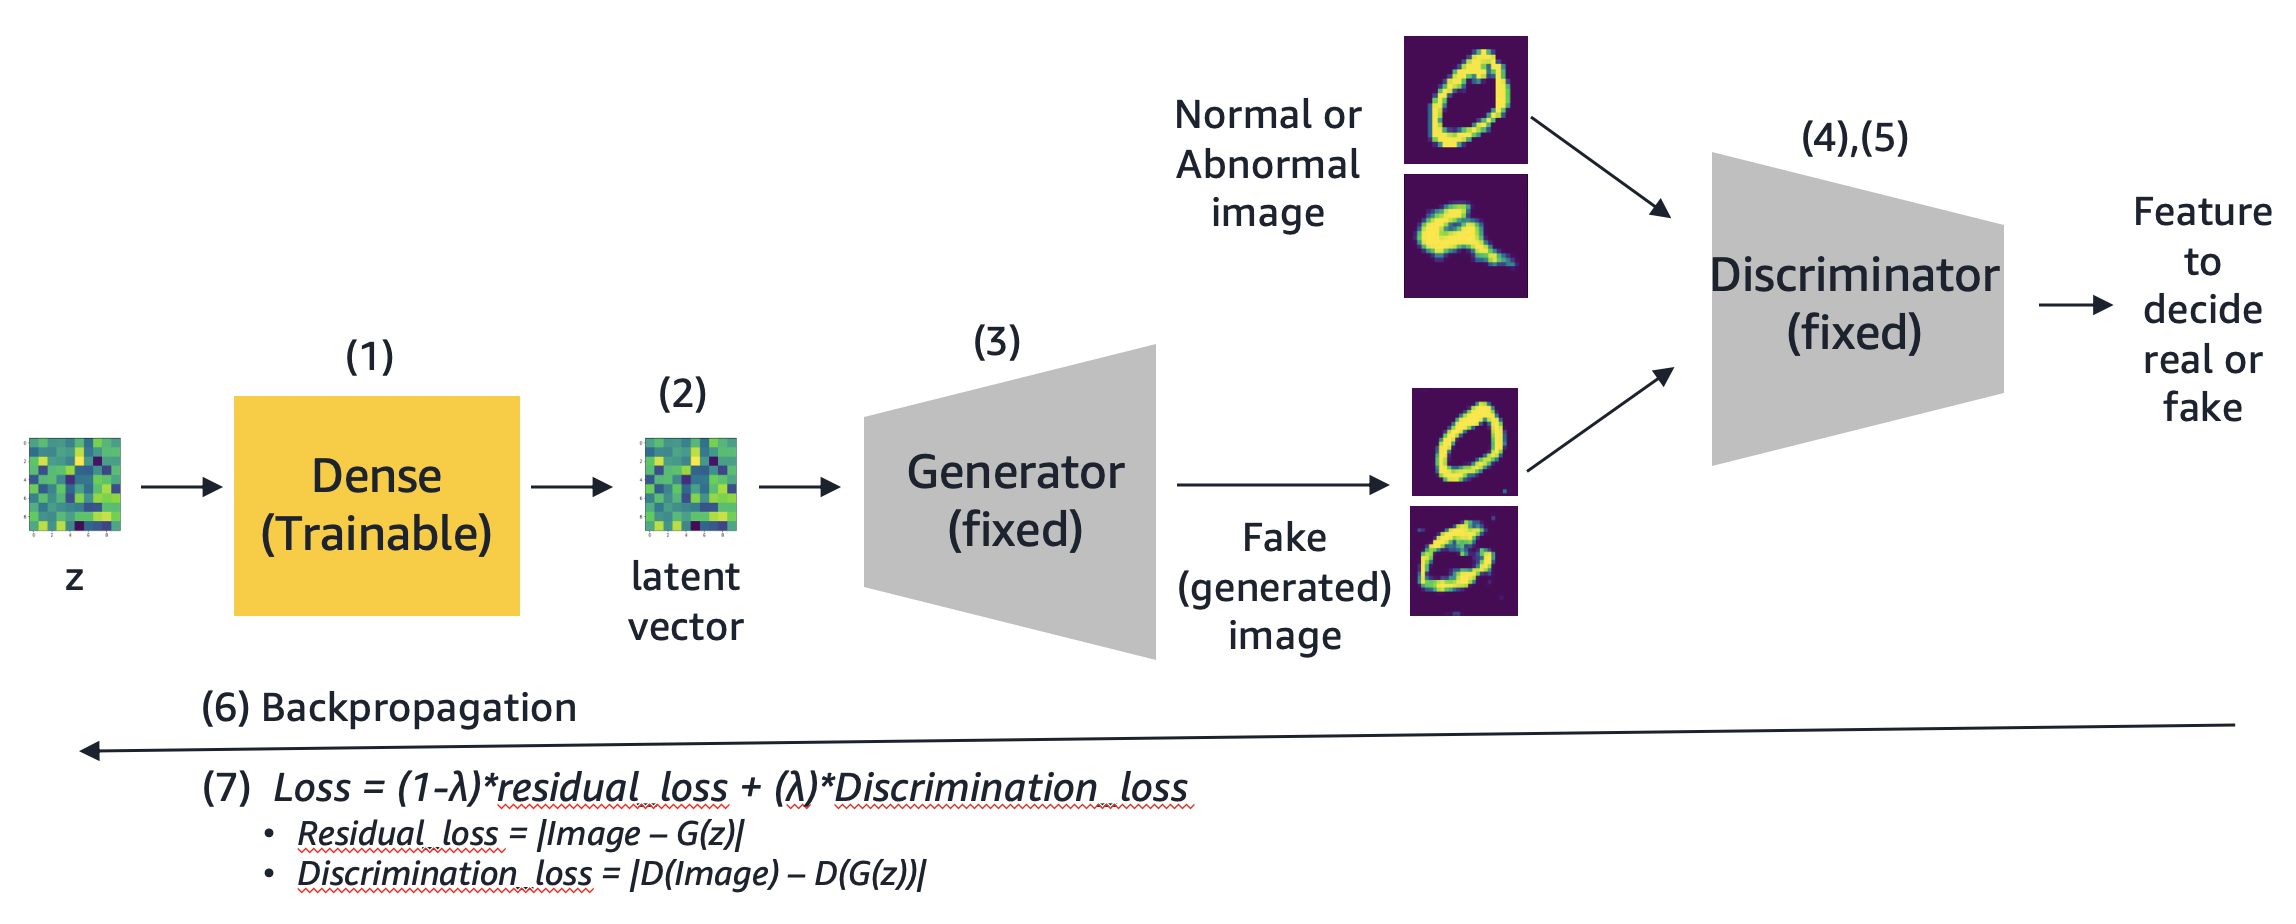

1. GAN은 기존의 역할데로 Random Noise를 입력받아서 Generator는 fake_image를 잘 생성하도록, Descriminator는 real_image와 fake_image를 구분하도록 학습된다.(중요: 이때 학습은 Normal data로만 시킨다.)

2. 이후 이렇게 잘 학습된 GAN의 가중치를 그대로 고정시킨다.

3. Generator의 Random Noise의 input 이전에 Dense Layer를 추가한다.
  - 그러면 이제 이 모델을 돌리면 Random Noise가 Dense Layer를 통과한 이후 Generator를 지나 Discriminator로 들어가게 된다. (G와 D의 가중치는 고정되어있다.)

4. 앞서 학습된 Discriminator의 중간 layer에서 결과를 뽑아보면 real_image와 Generator가 잘 생성한 real image같은 fake_image의 feature_vector를 뽑을 수 있다. 

5. 이러한 상태에서 Random Noise를 input으로 넣는데 이때 Generator가 생성하는 fake_image와 Discriminator를 통과한 fake_feature vector 그리고 real_image와 Discriminator를 통과한 fake_feature vector 각각의 차이가 최소가 되도록 Dense Layer를 학습시킨다.

  - 즉 실제 이미지 X와 generator가 random noise로 생성한 이미지의 차이 + 실제 이미지 X가 discriminator로 입력되었을때의 feature vector와 생성한 이미지 X가 discriminator로 입력되었을때의 feature vector의 차이를 구한다.

6. 이때 이 두개의 Loss가 최소화가 되도록 학습을 진행하면 Dense Layer는 random_noise가 더 명확한 진짜 이미지 즉 여기서 Normal Image를 잘 생성하도록 학습이 된다.

반면, Discriminator에 AbNormal image가 입력된다면 위와 같은 방식으로 학습되었기에 Normal image를 생성하지 못함과 동시에 loss도 클 것이다. 

따라서 이때의 loss를 Anomaly Score로 잡아서 판단 기준으로 사용한다.

# 0. Setting

### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Dense, Flatten
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

### Load Data and Train/Test Split
- Normal: 0, Abnormal: 8
- Normal data만을 가지고 DCGAN 학습
- Normal/Abnormal data를 이용해서 학습된 모델 테스트

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normal Train Data
index = np.where(train_labels == 0)
(train_images, train_labels) = (train_images[index], train_labels[index])

# Normal Test Data 
index = np.where(test_labels == 0)
(test_images_normal, test_labels_normal) = (test_images[index], test_labels[index])

# class가 0인 데이터만 normal data

# Abnormal Test Data
index = np.where(test_labels == 8)
(test_images_abnormal, test_labels_abnormal) = (test_images[index], test_labels[index])

# class가 8인 데이터 abnormal data

# 5923(데이터), 28(픽셀), 28(픽셀), 1(채널-흑백)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images_normal = test_images_normal.reshape(test_images_normal.shape[0], 28, 28, 1).astype('float32')
test_images_abnormal = test_images_abnormal.reshape(test_images_abnormal.shape[0], 28, 28, 1).astype('float32')

# 이미지 픽셀 값 [-1, 1]로 정규화 : 마지막 활성화 함수에서 tanh 사용(-1~1)
train_images = (train_images - 127.5) / 127.5
test_images_normal = (test_images_normal - 127.5) / 127.5
test_images_abnormal = (test_images_abnormal - 127.5) / 127.5

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_images.shape

(5923, 28, 28, 1)

In [4]:
BUFFER_SIZE = 5923 # 처음 N개의 data를 가져오는 parameter : 한번에 shufle할 데이터를 담는 그릇
BATCH_SIZE = 128

In [5]:
# 데이터 배치 생성
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 1. DCGAN Model

### Generator
1. Random Noise (Seed) 값으로부터 이미지 생성하기 위해 처음 Dense layer는 Seed 값을 Input으로 받음
2. 원하는 사이즈 (28x28x1)의 이미지가 나오도록 Upsampling 여러번 진행
3. 활성화 함수 지정: 마지막 층에서는 Tanh 사용, 나머지 층에서는 LeakyReLU 사용

* assert

In [9]:
'''a = 2
b = 3
assert a + b == 6'''

'a = 2\nb = 3\nassert a + b == 6'

In [10]:
a = 2
b = 3
assert a + b == 5

In [11]:
def make_generator_model():
  # random noise를 입력받아서 image를 생성하기 위한 generator
  
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100, )))
  model.add(layers.Reshape((7, 7, 128)))

  model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 14, 14, 128) # 배치사이즈로 None이 주어짐

  model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 14, 14, 64)

  model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

##### Train 되지 않은 Generator로 이미지 생성

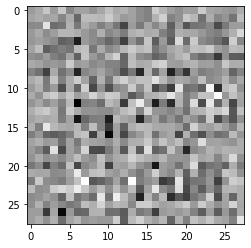

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              627200    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147456    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       7

### Discriminator
- CNN 기반 이미지 분류기와 동일

In [14]:
def make_discriminator_model():
  # 생성된 이미지와 진짜 이미지를 입력받을 discriminator : 우리는 noraml data로만 학습한다.
  
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same',
                          input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

##### Train 되지 않은 Discriminator를 이용해서 판별
- 진짜 이미지에는 양수를, 가짜 이미지에는 음수를 출력하도록 훈련

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00339968]], shape=(1, 1), dtype=float32)


In [16]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)        

### Loss Function & Optimizer

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# from_logits = True : 모델의 출력값이 문제에 맞게 normalize 되었는지의 여부
# 10개의 이미지를 분류한다고 했을때 softmax로 출력을 사용한다면 logits이 아니라 확률 값이기에 False

##### Discriminator Loss Function
- Discriminator가 가짜 이미지와 진짜 이미지를 얼마나 잘 구별하는지를 수치화
- 진짜 이미지에 대한 Discriminator의 예측과 1로 이루어진 행렬을 비교
- 생성된 가짜 이미지에 대한 Discriminator의 예측과 0으로 이루어진 행렬을 비교

In [18]:
def discriminator_loss(real_output, fake_output):
  
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  # 진짜 이미지의 output을 넣고 1로 학습
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  # 가짜 이미지의 output을 넣고 0으로 학습
  total_loss = real_loss + fake_loss

  return total_loss

##### Generator Loss Function
- Generator가 Discriminator를 얼마나 잘 속였는지를 수치화
- Generator가 잘 수행되고 있다면 Discriminator는 가짜 이미지를 1(진짜)로 분류할 것
- 생성된 이미지에 대한 Discriminator의 결정을 1로 이루어진 행렬과 비교

In [19]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)
  # 가짜 이미지의 output을 넣고 1로 학습

##### Optimizer

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##### Check Point

In [21]:
def save_models(epoch, discriminator, generator, path='./training_checkpoints'):

  discriminator.save_weights('{}/d-{}.ckpt'.format(path, epoch))
  generator.save_weights('{}/g-{}.ckpt'.format(path, epoch))
  # 가중치를 저장하는 코드를 함수

→ 잘 학습된 모델의 가중치를 저장한 다음 AnoGAN 학습을 위해서 동결시킨채로 사용할 것.

### Define Train Loop

In [22]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
# seed를 다시 사용하기 위해서 : 테스트할때 동일한 노이즈를 계속 넣을 것.

In [23]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.73234636,  0.3944809 , -0.74680483, ...,  0.4875659 ,
         0.05414855,  0.03504813],
       [-0.8513007 ,  1.4273821 , -0.57523364, ..., -0.33664438,
         0.05531473,  0.48002082],
       [ 2.529123  ,  0.30720374,  0.02286662, ...,  2.0057461 ,
        -1.1104052 , -0.75305223],
       ...,
       [ 1.9195648 , -1.6420151 , -0.32303098, ..., -0.1192845 ,
        -0.6037435 , -0.48201102],
       [ 0.69809735, -0.651376  , -1.8337859 , ..., -2.1282244 ,
         0.3951453 , -0.4101154 ],
       [-1.9592818 ,  0.75146073, -1.7330307 , ..., -0.11746939,
        -0.31183675,  0.62609124]], dtype=float32)>

In [24]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    # 시작 시간

    for image_batch in dataset:
      train_step(image_batch)
      # 학습을 진행.

    # GIF를 위한 이미지를 바로 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # 아래에 구현한 함수

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # 에포크 이후 시간 출력
    
  # 마지막 에포크가 끝난 후 생성
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  # 이미지를 생성하고 저장하는 함수 아래에 구현.
  
  save_models(epochs, discriminator, generator, './training_checkpoints')
  # 모델 저장

In [26]:
def generate_and_save_images(model, epoch, test_input):
  
  predictions = model(test_input, training=False) # training=False
  # 고정된 noise의 test 이미지를 입력해서 예측해본다. 
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Train Model

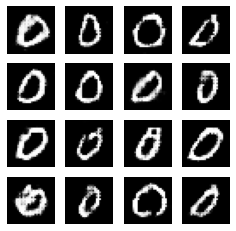

CPU times: user 1min 31s, sys: 2.27 s, total: 1min 33s
Wall time: 1min 48s


In [27]:
%%time
train(train_dataset, EPOCHS)

# 2. AnoGAN - Anomaly Detection

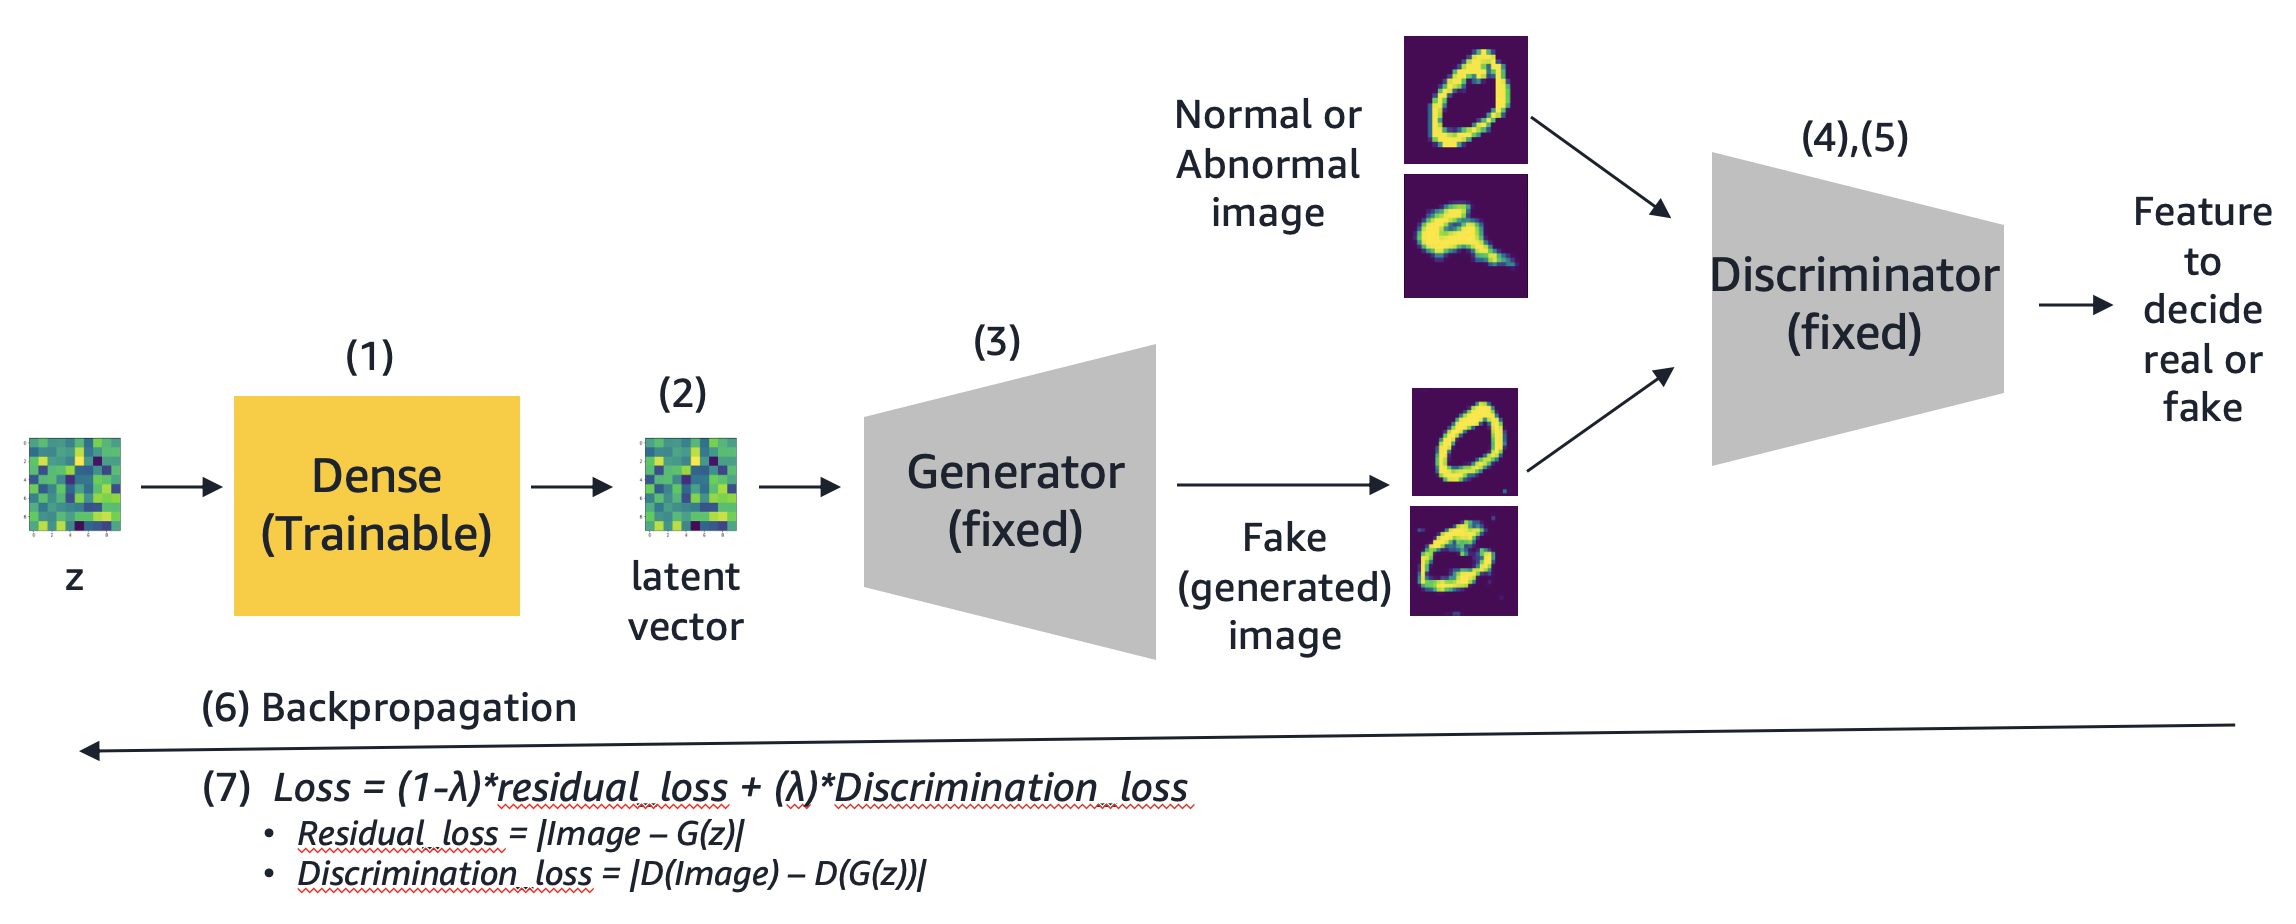


1. Random noise z를 생성해 Dense layer에 입력
2. z가 Dense layer를 지나 Latent vector를 생성
3. Latent vector는 앞서 훈련된 Generator를 지나 Random image 생성
4. 생성된 이미지가 앞서 훈련된 Discriminator를 지나 Real/Fake 판단을 위한 중간 Feature vector 생성
5. Normal/Abnormal 판단이 필요한 새로운 Image를 이용해 3, 4에 대한 Ground Truth 값을 생성 
(즉, Image는 3의 Ground Truth 역할을 하고, 해당 Image로부터 Discriminator 연산을 통해 생성된 Feature vector는 4에 대한 Ground Truth가 됨)
6. 생성된 값들(Image와 Feature vector)을 Ground Truth와 비교하며 Backpropagation을 통해 Dense layer를 학습해 z 업데이트 
7. Training을 위한 Loss 자체를 Anomaly score로 활용

* 앞서 정상 데이터로만 훈련된 Generator와 Discriminator의 parameter 값들은 고정
* 학습과정에서 사용했던 데이터 (=정상데이터)일수록 학습이 더 잘 될 것

### Extract feature vector from Discriminator

In [28]:
def feature_extractor(img_shape=(28, 28, 1)):

  d = make_discriminator_model()
  # discriminator
  d.load_weights('./training_checkpoints/d-100.ckpt')
  # 잘 훈련한 가중치 : 100 epoch
  intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-6].output)
  # 중간 layer만 뽑아서 Model로 사용 : feature vector를 뽑기 위해.
  intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')

  return intermidiate_model

In [29]:
make_discriminator_model().layers

In [30]:
make_discriminator_model().layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_8_input')>

In [31]:
make_discriminator_model().layers[-6].output

<KerasTensor: shape=(None, 4, 4, 128) dtype=float32 (created by layer 'dropout_14')>

### Generate Latent vector & Load Generator and Feature_extrctor

In [32]:
def gne_anogan(loss, latent_dim=100, channels=1, img_shape=(28, 28, 1)):
  g = make_generator_model()
  # generator model
  g.load_weights('./training_checkpoints/g-100.ckpt')
  # 잘 훈련한 가중치
  g.trainable = False
  # 가중치 동결
  intermidiate_model = feature_extractor(img_shape)
  # 위에서 정의한 discriminator에서 feature vector를 뽑는 모델
  intermidiate_model.trainable = False
  # 위에서 정의한 모델을 False

  z = Input(shape=(100, ))
  # input size : random noise
  gInput = Dense((100))(z)
  # generator 앞의 Dense Layer 설정

  G_out = g(gInput)
  # Dense Layer 통과 후, generator 통과. : 잘 생성된 fake image
  D_out = intermidiate_model(G_out)
  # generator 통과후 discriminator layer를 통과 : feature vector 추출.
  
  model = Model(inputs=z, outputs=[G_out, D_out])
  # 위의 전체 과정을 모델화.
  model.compile(loss=sum_of_residual, loss_weights=[0.9, 0.1], optimizer='adam')
  # loss_weight : 논문에 있는 가중치 사용.
  return model

In [33]:
def sum_of_residual(y_true, y_pred):
  # 실제값과 예측값을 입력받아서 차이의 절대값의 합을 출력
  
  return tf.reduce_sum(abs(y_true - y_pred))

In [34]:
model = gne_anogan(loss=sum_of_residual)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         849728    
                                                                 
 model (Functional)          (None, 4, 4, 128)         92672     
                                                                 
Total params: 952,500
Trainable params: 10,100
Non-trainable params: 942,400
_________________________________________________________________


### Test Normal Data

* 정상 이미지를 한장 넣을 것이다. 이 이미지를 넣어서 500 epoch를 돌릴텐데 이 이미지가 정상이라면 random noise가 dense layer를 통해 학습되어 정확하게 복원이 가능해질 것이다.

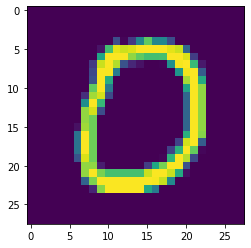

In [35]:
nimg = test_images_normal[1].reshape(28, 28)
# 정상 test image 한장.
plt.figure(figsize=(4,4))
plt.imshow(nimg)

In [36]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
# random noise 
intermidiate_model = feature_extractor(img_shape=(28,28,1))

# ground truth
x = nimg.reshape(1,28,28,1)
# 위에서 시각화한 이미지 0 : normal data
d_x = intermidiate_model.predict(x)
# 실제 이미지에서 추출한 feature vector

# ground truth를 예측하는 z 학습
loss = model.fit(z, [x, d_x], epochs=500, verbose=0)
# model에 z를 넣으면 z로 만든 fake img와 추출한 feature vector가 output으로 나온다.
# 그 output과 real img, real img를 입력하여 추출한 feature vector의 차이를 줄이도록 학습한다.

CPU times: user 4.25 s, sys: 247 ms, total: 4.49 s
Wall time: 3.88 s


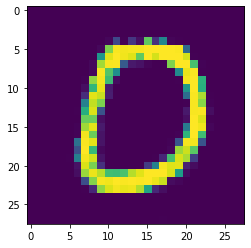

In [37]:
o1, o2 = model.predict(z)
# o1은 image, o2는 feature vector
plt.figure(figsize=(4,4))
plt.imshow(o1.reshape(28,28))

In [38]:
loss.history['loss'][-1]

32.479278564453125

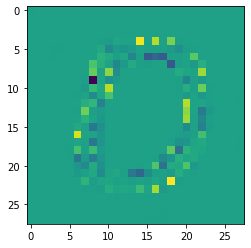

In [39]:
plt.figure(figsize=(4,4))
plt.imshow(nimg - o1.reshape(28,28))
# 실제 이미지와 model 출력 이미지의 차이를 시각화

→ 크게 차이가 나지 않음을 확인

### Test Abnormal Data

* 비정상 이미지를 한장 넣을 것이다. 이 비정상 이미지를 500 epoch 학습하더라도 이 이미지를 생성하게 만들어진 모델이 아니기에(정상 이미지로만 학습이 되었기에) 어느정도는 비슷해지더라도 동일한 이미지를 생성할 수 없을 것이다.

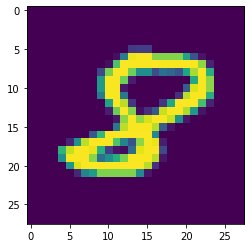

In [40]:
aimg = test_images_abnormal[0].reshape(28, 28)
# 비정상 데이터 
plt.figure(figsize=(4,4))
plt.imshow(aimg)

In [41]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(28,28,1))

# ground truth
x = aimg.reshape(1, 28, 28, 1)
# 비정상데이터
d_x = intermidiate_model.predict(x)
# 비정상 데이터로 출력한 feature vector

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)
# model에 z를 넣으면 z로 만든 fake img와 추출한 feature vector가 output으로 나온다.
# 그 output과 real img, real img를 입력하여 추출한 feature vector의 차이를 줄이도록 학습한다. 

CPU times: user 3.25 s, sys: 257 ms, total: 3.5 s
Wall time: 5.3 s


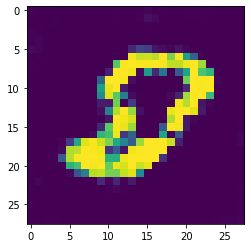

In [42]:
oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(oa1.reshape(28,28))

In [44]:
loss_a.history['loss'][-1]

81.56949615478516

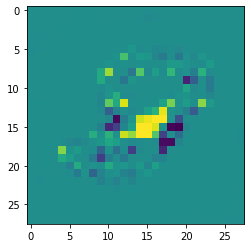

In [45]:
plt.figure(figsize=(4,4))
plt.imshow(aimg - oa1.reshape(28,28))
# 입력한 비정상이미지와 생성한 이미지의 차이

→ 학습 이후의 두 경우의 Error를 비교했을때 비정상 이미지가 두개 가량 높은 것을 확인할 수 있다. 

### Results
- 각 100개의 Normal Data와 Abnormal Data를 이용하여 Anomaly Score 비교

In [46]:
nimg_multi = test_images_normal[:100]

In [47]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(28, 28, 1))

# ground truth
x = nimg_multi.reshape(100, 28, 28, 1)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_normal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 9.27 s, sys: 586 ms, total: 9.86 s
Wall time: 8.44 s


In [48]:
aimg_multi = test_images_abnormal[:100]

In [49]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(28,28,1))

# ground truth
x = aimg_multi.reshape(100, 28, 28, 1)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_abnormal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 9.24 s, sys: 532 ms, total: 9.77 s
Wall time: 10.4 s


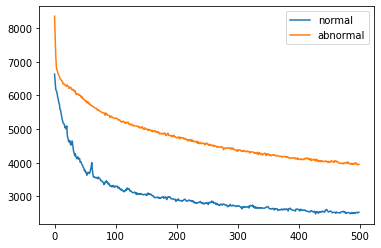

In [50]:
plt.plot(loss_normal.history['loss'])
plt.plot(loss_abnormal.history['loss'])
plt.legend(['normal','abnormal'])
plt.show()

→ 비정상데이터의 Error가 압도록으로 큰 것을 볼 수 있다.